In [3]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from tqdm import tqdm

# 图像预处理：统一大小并进行标准化
transform = transforms.Compose([
    transforms.Resize((32, 32)),  
    transforms.ToTensor(),       
    transforms.Normalize((0.5,), (0.5,))  
])

# 自定义数据集类，用于加载图像和标签
class TinySegDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        """
        :param annotations_file: 标签文件路径
        :param img_dir: 图像所在的目录
        :param transform: 图像预处理
        """
        self.annotations_file = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        
        # 读取标签文件
        with open(annotations_file, 'r') as f:
            self.annotations = f.readlines()
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        # 获取标签和图像路径
        line = self.annotations[idx].strip()
        img_name, label = line.split(": ")
        img_path = os.path.join(self.img_dir, img_name)
        
        # 打开图像
        image = Image.open(img_path).convert('RGB')
        
        # 应用预处理
        if self.transform:
            image = self.transform(image)
        
        return image, int(label)

# 实例化数据集
annotations_file = r"C:\Users\Yet Young\Desktop\documents\ML\tiny_seg_exp\TinySeg\labels.txt"  # 替换为你的标签文件路径
img_dir = r"C:\Users\Yet Young\Desktop\documents\ML\tiny_seg_exp\TinySeg\Annotations"  # 图像所在的目录
dataset = TinySegDataset(annotations_file, img_dir, transform)


test_size = 624
train_size = len(dataset) - test_size

# 切分数据集
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 自定义的多头自注意力模块
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.emb_dim = emb_dim
        self.head_dim = emb_dim // num_heads
        
        # 确保嵌入维度是头数的倍数
        assert emb_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads."
        
        # 定义 Q, K, V 投影
        self.query_proj = nn.Linear(emb_dim, emb_dim)
        self.key_proj = nn.Linear(emb_dim, emb_dim)
        self.value_proj = nn.Linear(emb_dim, emb_dim)
        
        # 输出投影
        self.out_proj = nn.Linear(emb_dim, emb_dim)

    def forward(self, query, key, value):
        batch_size = query.size(0)

        # 线性映射，得到 Q, K, V
        Q = self.query_proj(query).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key_proj(key).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value_proj(value).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        # 计算注意力得分
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (batch, heads, seq_len, seq_len)
        attention_weights = torch.softmax(attention_scores, dim=-1)

        # 计算加权的值
        out = torch.matmul(attention_weights, V)  # (batch, heads, seq_len, head_dim)
        out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.emb_dim)  # 拼接多个头的输出

        # 输出线性层
        out = self.out_proj(out)
        return out

# 前馈网络
class FeedForward(nn.Module):
    def __init__(self, emb_dim, ff_dim):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(emb_dim, ff_dim)
        self.fc2 = nn.Linear(ff_dim, emb_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Transformer 编码器层
class TransformerEncoderLayer(nn.Module):
    def __init__(self, emb_dim, num_heads, ff_dim):
        super(TransformerEncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(emb_dim, num_heads)
        self.feed_forward = FeedForward(emb_dim, ff_dim)
        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # 多头自注意力
        attention_out = self.attention(x, x, x)
        x = self.layer_norm1(x + self.dropout(attention_out))  # 残差连接 + LayerNorm

        # 前馈网络
        ff_out = self.feed_forward(x)
        x = self.layer_norm2(x + self.dropout(ff_out))  # 残差连接 + LayerNorm

        return x

# Vision Transformer (ViT)
class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, emb_dim, num_heads, num_layers, ff_dim):
        super(VisionTransformer, self).__init__()

        self.patch_size = patch_size
        self.image_size = image_size
        self.num_patches = (image_size // patch_size) ** 2
        self.emb_dim = emb_dim

        # 将图像分块
        # 修改卷积层的输入通道为3（因为图像为RGB三通道）
        self.patch_embed = nn.Conv2d(3, emb_dim, kernel_size=patch_size, stride=patch_size)

        # 位置编码
        self.positional_encoding = nn.Parameter(torch.randn(1, self.num_patches, emb_dim))

        # Transformer 层
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(emb_dim, num_heads, ff_dim) for _ in range(num_layers)
        ])

        # 分类头
        self.fc = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        # 获取 patch 嵌入
        x = self.patch_embed(x)  # 输出形状 (batch_size, emb_dim, num_patches_height, num_patches_width)
        x = x.flatten(2).transpose(1, 2)  # 形状变为 (batch_size, num_patches, emb_dim)

        # 加入位置编码
        x = x + self.positional_encoding

        # 通过所有 Transformer 层
        for layer in self.encoder_layers:
            x = layer(x)

        # 分类
        x = x.mean(dim=1)  # Global average pooling
        x = self.fc(x)
        return x


In [5]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

Epoch 1/10, Train Loss: 0.7987, Train Accuracy: 74.12%, Test Loss: 0.2558, Test Accuracy: 90.38%
Epoch 2/10, Train Loss: 0.1601, Train Accuracy: 95.28%, Test Loss: 0.1493, Test Accuracy: 96.47%
Epoch 3/10, Train Loss: 0.1447, Train Accuracy: 95.68%, Test Loss: 0.1557, Test Accuracy: 96.79%
Epoch 4/10, Train Loss: 0.2321, Train Accuracy: 93.52%, Test Loss: 0.1845, Test Accuracy: 95.83%
Epoch 5/10, Train Loss: 0.1797, Train Accuracy: 95.05%, Test Loss: 0.1229, Test Accuracy: 96.79%
Epoch 6/10, Train Loss: 0.1454, Train Accuracy: 95.35%, Test Loss: 0.1004, Test Accuracy: 96.63%
Epoch 7/10, Train Loss: 0.0845, Train Accuracy: 97.12%, Test Loss: 0.0698, Test Accuracy: 97.12%
Epoch 8/10, Train Loss: 0.0641, Train Accuracy: 97.77%, Test Loss: 0.0637, Test Accuracy: 97.76%
Epoch 9/10, Train Loss: 0.0699, Train Accuracy: 97.42%, Test Loss: 0.0633, Test Accuracy: 97.76%
Epoch 10/10, Train Loss: 0.0694, Train Accuracy: 97.82%, Test Loss: 0.0858, Test Accuracy: 97.28%


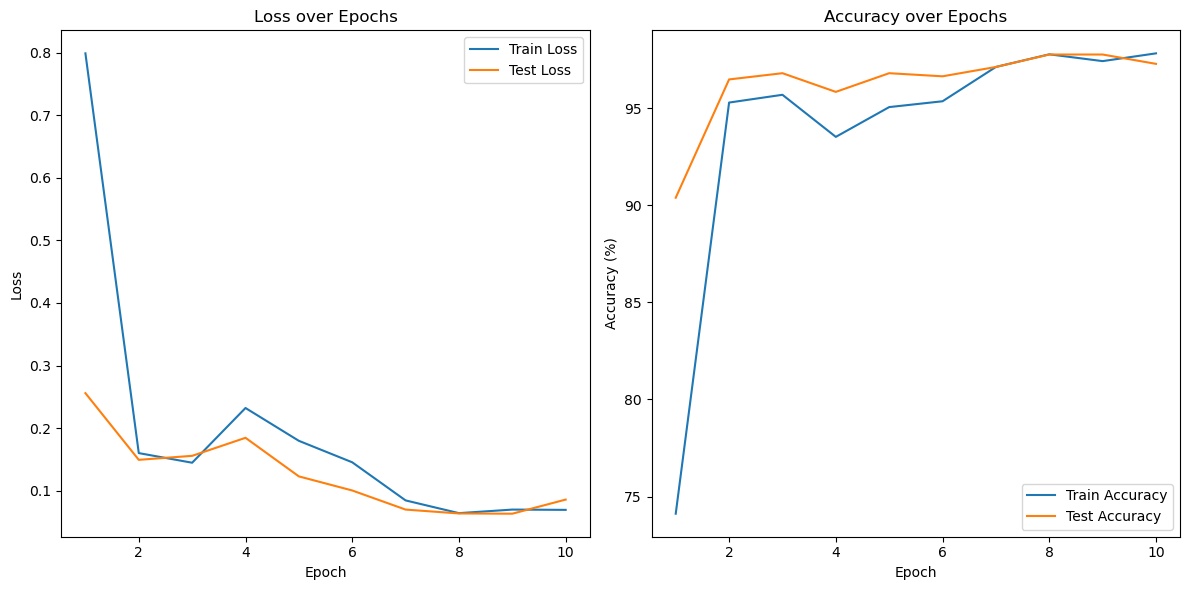

In [6]:
# 初始化模型
model = VisionTransformer(image_size=28, patch_size=7, num_classes=10, emb_dim=128, num_heads=4, num_layers=6, ff_dim=512)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 损失函数与优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 存储损失和准确度以便可视化
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# checkpoint 保存路径
checkpoint_path = "vit_checkpoint.pth"


start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Resuming from epoch {start_epoch + 1}")

# 训练模型
epochs = 10
for epoch in range(start_epoch, epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # 记录训练损失和准确度
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 测试模型
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # 记录测试损失和准确度
    test_loss = test_loss / len(test_loader)
    test_accuracy = correct / total * 100
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, checkpoint_path)


epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()